## Milestone 4; Movie Recommendation Model with Naïve Bayes

### Load Data

In [10]:
import pandas as pd

base_path = './ml-100k/'

# 1. Load ratings (u.data: tab-separated userId | movieId | rating | timestamp)
ratings_cols = ['userId','movieId','rating','timestamp']
ratings = pd.read_csv(
    f'{base_path}u.data',
    sep='\t',
    names=ratings_cols,
    engine='python'
)

# 2. Load movies (u.item: pipe-separated; first 5 cols + 19 genre flags)
item_cols = ['movieId','title','release_date','video_release_date','IMDb_URL']
genre_cols = [
    'unknown','Action','Adventure','Animation',"Children's",'Comedy','Crime',
    'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
    'Romance','Sci-Fi','Thriller','War','Western'
]
movies = pd.read_csv(
    f'{base_path}u.item',
    sep='|',
    names=item_cols + genre_cols,
    encoding='latin-1',
    engine='python'
)

# 3. Quick sanity-check
print(ratings.head())
print(movies.head())


   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596
   movieId              title release_date  video_release_date  \
0        1   Toy Story (1995)  01-Jan-1995                 NaN   
1        2   GoldenEye (1995)  01-Jan-1995                 NaN   
2        3  Four Rooms (1995)  01-Jan-1995                 NaN   
3        4  Get Shorty (1995)  01-Jan-1995                 NaN   
4        5     Copycat (1995)  01-Jan-1995                 NaN   

                                            IMDb_URL  unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...        0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...        0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...        0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...        0       1   
4  http://

## Model Implementation

In [11]:
movies_final = movies.drop(['title', 'release_date', 'video_release_date', 'IMDb_URL'], axis = 1).set_index('movieId')
user_rating = ratings[ratings['userId'] == 1]
user_rating_cleaned = user_rating.reset_index()[['movieId', 'rating']]
user_rating_cleaned['rating'] = user_rating_cleaned['rating'].isin([4,5])
user_rating_cleaned


,movieId,rating
0,61,True
1,189,False
2,33,True
3,160,True
4,20,True
...,...,...
267,28,True
268,172,True
269,122,False
270,152,True


### Naïve Bayes Recommendation

In [12]:
movies_final = movies.drop(['title', 'release_date', 'video_release_date', 'IMDb_URL'], axis = 1).set_index('movieId')
def user_df(userID):
  user_rating = ratings[ratings['userId'] == userID]
  user_rating_cleaned = user_rating.reset_index()[['movieId', 'rating']]
  user_rating_cleaned['rating'] = user_rating_cleaned['rating'].isin([4,5])
  return user_rating_cleaned
user_rating_cleaned = user_df(1)
user_rating_cleaned


def p_X_given_y(row, reviews): #returns P(x_1 | y), P(x_2 | y), P(x_3 | y)...
    matches = (reviews.values == row.values).sum(axis=0)
    return (1 + matches) / (1 + len(reviews))  #P(X | y) = count(X, y) / count(y), with laplace smoothing

def p_y_given_X(row, movies_final, ratings_final): #P(y | X) ∝ P(Y) * ∏ P(X | y)
    p_y = ratings_final['rating'].mean() #P(Y) = count(Y) / count(All)
    good_review_ids = ratings_final[ratings_final['rating']]['movieId']
    p_X_given_y_vector = p_X_given_y(row, movies_final.loc[good_review_ids]) #P(x_1 | y), P(x_2 | y), P(x_3 | y)...
    return p_y * p_X_given_y_vector.prod() #P(y | X) ∝ P(Y) * ∏ P(x_i | y)

def p_y_0_given_X(row, movies_final, ratings_final): #P(y | X) ∝ P(Y) * ∏ P(X | y)
    p_y = 1 - ratings_final['rating'].mean() #P(Y) = count(Y) / count(All)
    bad_review_ids = ratings_final[~ratings_final['rating']]['movieId']
    p_X_given_y_vector = p_X_given_y(row, movies_final.loc[bad_review_ids]) #P(x_1 | y), P(x_2 | y), P(x_3 | y)...
    return p_y * p_X_given_y_vector.prod() #P(y | X) ∝ P(Y) * ∏ P(x_i | y)

# compute P(y|X) for all unwatched movies
# accepts as input the whole dataframe of all movies(final_df), and the dataframe of all watched movies by the user(watched_df)
def naive_bayes(movies_final, user_rating_cleaned):
    unwatched_df = movies_final[~movies_final.index.isin(user_rating_cleaned['movieId'])].copy()
    p_y_given_X_col = unwatched_df.apply(p_y_given_X, axis = 1, args = (movies_final, user_rating_cleaned))
    p_y_0_given_X_col = unwatched_df.apply(p_y_0_given_X, axis = 1, args = (movies_final, user_rating_cleaned))
    unwatched_df['p_y_given_X'] = p_y_given_X_col
    unwatched_df['p_y_0_given_X'] = p_y_0_given_X_col
    unwatched_df['pred_rating'] = (unwatched_df['p_y_given_X'] > unwatched_df['p_y_0_given_X']).astype(int)
    return unwatched_df.sort_values(by = 'p_y_given_X', ascending = False)[['p_y_given_X', 'pred_rating']]

naive_bayes(movies_final, user_rating_cleaned)  # Randomly select 20% of the DataFrame as watched

,p_y_given_X,pred_rating
movieId,,
1682,4.878166e-02,1
1005,4.878166e-02,1
1564,4.878166e-02,1
985,4.878166e-02,1
981,4.878166e-02,1
...,...,...
993,1.783629e-07,0
426,1.502854e-07,0
560,7.570921e-08,0


### Train / Test Split

/Users/christat/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/christat/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


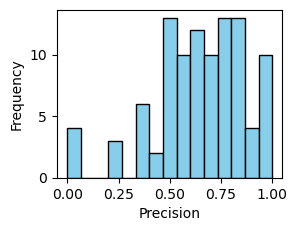

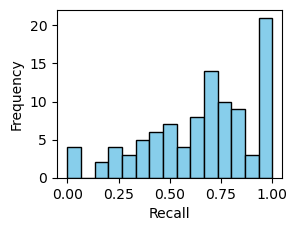

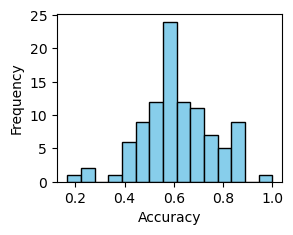

Precision: 0.6428
Recall: 0.6507
Accuracy: 0.6109


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

users = np.random.randint(930, size=100)
results_matrix = []
for user in users:
  user_rating_cleaned = user_df(user)
  train_data, test_data = train_test_split(user_rating_cleaned, test_size=0.2)
  train_predictions = naive_bayes(movies_final, train_data)
  test_data_with_predictions = pd.merge(train_predictions, test_data, left_index = True, right_on = 'movieId')
  test_data_with_predictions

  y_true = test_data_with_predictions['rating']
  y_pred = test_data_with_predictions['pred_rating']
  precision = precision_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  result = [precision, recall, accuracy]
  results_matrix.append(result)
results_matrix = np.array(results_matrix)

fig = plt.figure()
plt.subplot(2, 2, 1)
plt.hist(results_matrix[:, 0], bins = 15, color = 'skyblue', edgecolor='black')
plt.xlabel('Precision')
plt.ylabel('Frequency')
plt.locator_params(axis='y', integer = 'True')
plt.show()
plt.subplot(2, 2, 2)
plt.hist(results_matrix[:, 1], bins = 15, color = 'skyblue', edgecolor='black')
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.locator_params(axis='y', integer = 'True')
plt.show()
plt.subplot(2, 2, 3)
plt.hist(results_matrix[:, 2], bins = 15, color = 'skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.locator_params(axis='y', integer = 'True')
plt.show()
print(f"Precision: {results_matrix[:, 0].mean():.4f}")
print(f"Recall: {results_matrix[:, 1].mean():.4f}")
print(f"Accuracy: {results_matrix[:, 2].mean():.4f}")
